In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

## TODO: Remove later
_Code Refs_
https://github.com/tensorflow/tensorflow/blob/r2.0/tensorflow/lite/python/tflite_convert.py#L104
`converter_fn = lite.TFLiteConverter.from_keras_model_file
converter_kwargs["model_file"] = flags.keras_model_file`

Actual code in:
https://www.gitmemory.com/gargn
'''
model = tf.saved_model.load(export_dir)
concrete_func = model.signatures[
    tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
concrete_func.inputs[0].set_shape([1, 28, 28])
converter = tf.lite.TFLiteConverter.from_concrete_function(concrete_func)
tflite_model = converter.convert()
open("/tmp/mnist_fashion/converted_model.tflite", "wb").write(tflite_model)
'''
Note that the model has been saved with tf.saved_model, and not with keras convience function.

    

In [2]:
import sys
sys.path.append('../')  # so that we can import libs from other chapters and utils

from utils import emnist_utils

In [3]:
######## GPU HACK FOR RTX 2070 ###########
from tensorflow.keras import backend as K
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
K.set_session(session)

In [4]:
# Load train and test data from Chapter 1 location
train = {}
test = {}

train['features'], train['labels'] = emnist_utils.read_emnist('../Chapter1/data/emnist-bymerge-train-images-idx3-ubyte.gz', '../Chapter1/data/emnist-bymerge-train-labels-idx1-ubyte.gz')
test['features'], test['labels'] = emnist_utils.read_emnist('../Chapter1/data/emnist-bymerge-test-images-idx3-ubyte.gz', '../Chapter1/data/emnist-bymerge-test-labels-idx1-ubyte.gz')

In [5]:
mappings = emnist_utils.map_emnist_labels("../Chapter1/data/emnist-bymerge-mapping.txt")

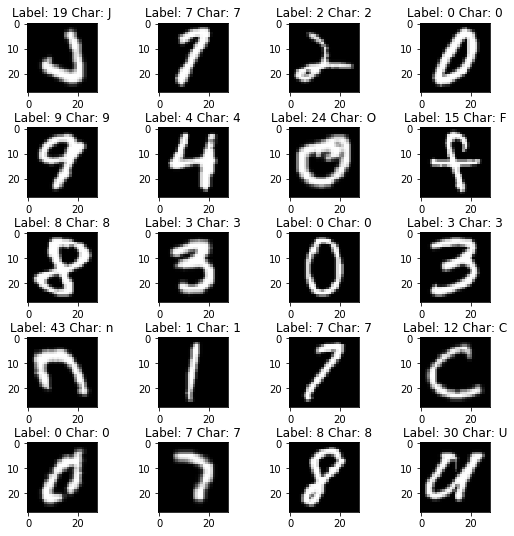

In [6]:
# Plot some images to verify we got the data right
emnist_utils.display_emnist_images(test['features'], test['labels'], mappings)

In [7]:
# Normalize the data
norm_train_features = keras.utils.normalize(train['features'])
norm_test_features = keras.utils.normalize(test['features'])

# one hot encode training labels
one_hot_train_labels = tf.one_hot(train['labels'], 47)
one_hot_test_labels = tf.one_hot(test['labels'], 47)

## Our first Convolutional Neural Network

In [8]:
# First the input layers
inputs = keras.Input(shape=(28,28,), name='emnist_inp')
x = layers.Reshape((28, 28, 1))(inputs)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu', name='dense_1')(x)
x = layers.Dense(128, activation='relu', name='dense_2')(x)
outputs = layers.Dense(47, activation='softmax', name='predictions')(x)

cnn = keras.Model(inputs=inputs, outputs=outputs, name='cnn_model_1')
cnn.summary()


Model: "cnn_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
emnist_inp (InputLayer)      [(None, 28, 28)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 10816)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2769152   
_________________________________________________________________
dense_2 (Dense)              (None, 128)               

In [9]:
# Lets compile the model and train it
cnn.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
history = cnn.fit(norm_train_features, one_hot_train_labels, epochs=10, batch_size=128)

Epoch 1/10
697932/697932 [==============================] - 32s 45us/sample - loss: 0.4622 - accuracy: 0.8451
Epoch 2/10
697932/697932 [==============================] - 31s 44us/sample - loss: 0.3170 - accuracy: 0.8856
Epoch 3/10
697932/697932 [==============================] - 30s 44us/sample - loss: 0.2868 - accuracy: 0.8942
Epoch 4/10
697932/697932 [==============================] - 31s 44us/sample - loss: 0.2665 - accuracy: 0.9001
Epoch 5/10
697932/697932 [==============================] - 30s 44us/sample - loss: 0.2501 - accuracy: 0.9045
Epoch 6/10
697932/697932 [==============================] - 31s 44us/sample - loss: 0.2365 - accuracy: 0.9087
Epoch 7/10
697932/697932 [==============================] - 31s 44us/sample - loss: 0.2245 - accuracy: 0.9117
Epoch 8/10
697932/697932 [==============================] - 31s 44us/sample - loss: 0.2146 - accuracy: 0.9148
Epoch 9/10
697932/697932 [==============================] - 31s 44us/sample - loss: 0.2052 - accuracy: 0.9182
Epoch 10/1

In [11]:
# Evaluate the model on the test set
cnn.evaluate(norm_test_features, one_hot_test_labels, 47)

116323/116323 [==============================] - 3s 29us/sample - loss: 0.3451 - accuracy: 0.8891


[0.3450824980268482, 0.88906753]

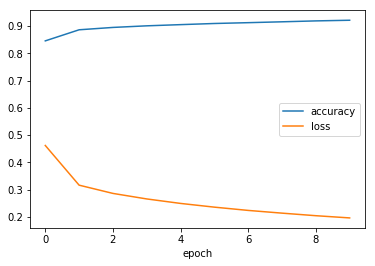

In [13]:
# Visualize the training
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.legend(['accuracy', 'loss'], loc='right')
plt.xlabel('epoch')
plt.show()

In [14]:
session.close()